In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch 
from celldreamer.paths import DATA_DIR

In [3]:
adata = sc.read_h5ad(DATA_DIR / 'sciplex' / 'sciplex_complete_middle_subset.h5ad')

In [4]:
adata.obs.columns

Index(['cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score',
       'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2',
       'product_dose', 'product_name', 'proliferation_index', 'replicate',
       'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val',
       'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug',
       'control', 'split_ho_pathway', 'split_tyrosine_ood',
       'split_epigenetic_ood', 'split_cellcycle_ood', 'SMILES',
       'split_ood_finetuning', 'split_ho_epigenetic',
       'split_ho_epigenetic_all', 'split_random'],
      dtype='object')

In [5]:
np.max(adata.X.A)

5.24875

In [6]:
np.min(adata.X.A)

0.0

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


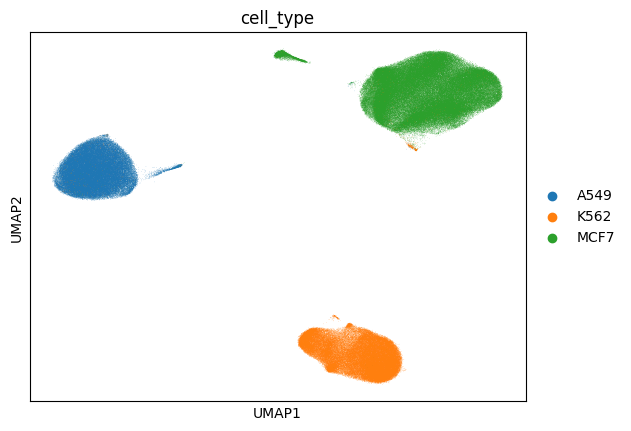

In [7]:
sc.pl.umap(adata, color="cell_type")

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


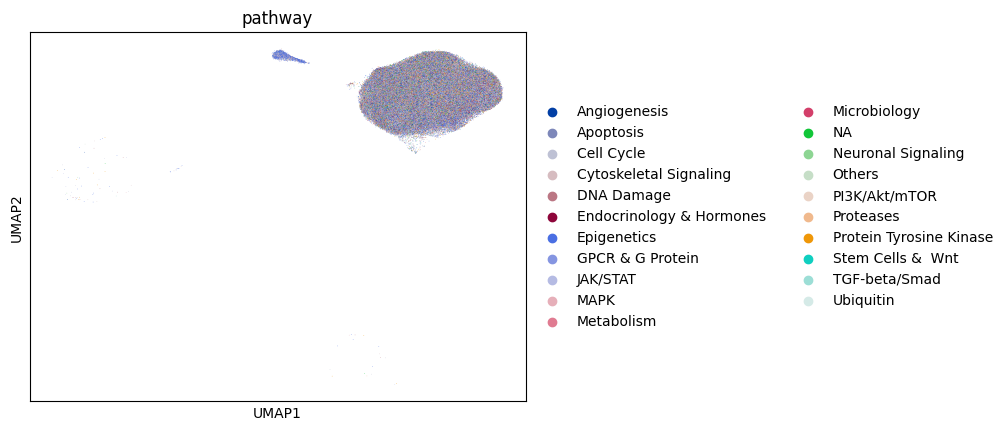

In [8]:
sc.pl.umap(adata[adata.obs.cell_type=="MCF7"], color="pathway")

In [9]:
adata.obs.cov_drug.value_counts()

MCF7_control       6358
K562_control       3359
A549_control       3287
MCF7_ENMD-2076     1678
MCF7_Fasudil       1248
                   ... 
K562_Epothilone     161
K562_Patupilone     156
K562_CUDC-907       155
A549_YM155           97
MCF7_YM155           41
Name: cov_drug, Length: 564, dtype: int64

**Check results of a diffusion model**

In [10]:
import yaml
from celldreamer.data.utils import Args
from celldreamer.estimator.celldreamer_estimator import CellDreamerEstimator

In [11]:
file_path = '/nfs/homedirs/pala/celldreamer/configs/perturbation_modelling/config_ddpm.yaml'

# Open the file and load its contents
with open(file_path, 'r') as file:
    config_dict = Args(yaml.safe_load(file)["args"])

In [12]:
estimator = CellDreamerEstimator(config_dict)

Create the training folders...
Initialize data module...


/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


ServiceStartTimeoutError: Timed out waiting for wandb service to start after 30.0 seconds. Try increasing the timeout with the `_service_wait` setting.

Traceback (most recent call last):
  File "/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/wandb/__main__.py", line 3, in <module>
    cli.cli(prog_name="python -m wandb")
  File "/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/click/core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/click/core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/click/core.py", line 1657, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/nfs/homedirs

In [ ]:
state_dict = torch.load("/nfs/students/pala/celldreamer/try_experiment/checkpoints/last-v5.ckpt")['state_dict']
estimator.generative_model.load_state_dict(state_dict)

In [ ]:
batch = next(iter(estimator.datamodule.valid_dataloader))
y = estimator.generative_model._featurize_batch_y(batch)

In [ ]:
obs = pd.DataFrame(y[:100].argmax(1).numpy()).astype("category")
obs.columns = ["cell_type"]

In [ ]:
with torch.no_grad():    
    gen = estimator.generative_model.generate(batch_size = 100, 
                                         y= y[:100], 
                                         z_t = None,
                                         T = 1000,
                                         get_intermediate_steps = False)

In [ ]:
adata = sc.AnnData(X=gen.cpu().numpy(),
                    obs=obs)

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")